In [1]:
# Kütüphanelerin import edilmesi
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
import kerastuner as kt
from kerastuner.tuners import RandomSearch
import warnings
warnings.filterwarnings("ignore")

2025-04-17 18:23:41.786338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744914221.809483     162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744914221.816385     162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_162/2951687535.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Veri setinin yüklenmesi
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [3]:
# Model oluşturma fonksiyonu
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=10000,
                        output_dim=hp.Int("embedding_output", min_value=32, max_value=128, step=32),
                        input_length=maxlen))
    model.add(GRU(units=hp.Int("gru_units", min_value=32, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    return model

In [4]:
# Hiperparametre araması
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=8,
    executions_per_trial=1,
    directory="rnn_tuner_directory",
    project_name="imdb_rnn"
)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2,
             callbacks=[early_stopping])

Trial 8 Complete [00h 00m 34s]
val_loss: 0.29176318645477295

Best val_loss So Far: 0.2693788409233093
Total elapsed time: 00h 06m 04s


In [5]:
# En iyi modeli değerlendir
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy, auc_score = best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss}, test accuracy: {accuracy:.3f}, test auc: {auc_score:.3f}")

# Tahmin yapma
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9533 - accuracy: 0.8849 - loss: 0.2778
Test loss: 0.27308714389801025, test accuracy: 0.888, test auc: 0.955
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12500
           1       0.89      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



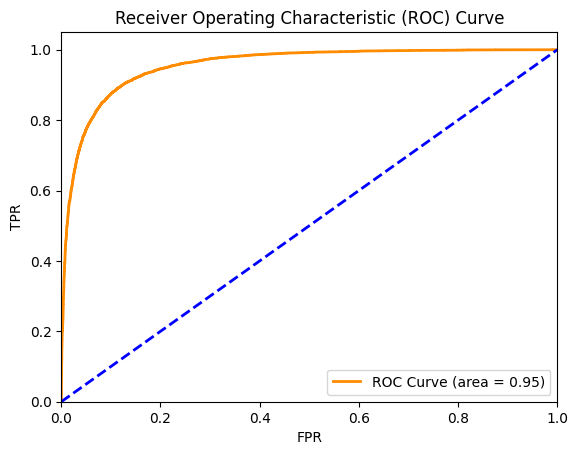

In [6]:
# ROC eğrisi
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC Curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1], color="blue", lw=2, linestyle="--")
plt.xlim([0,1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.savefig('roc_curve.png')

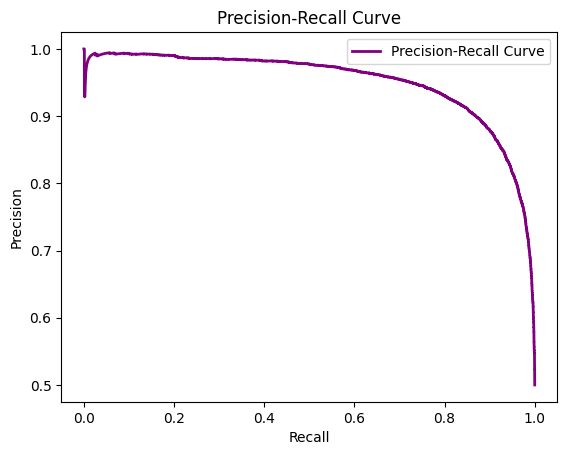

In [7]:
# Precision-Recall eğrisi
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('pr_curve.png')

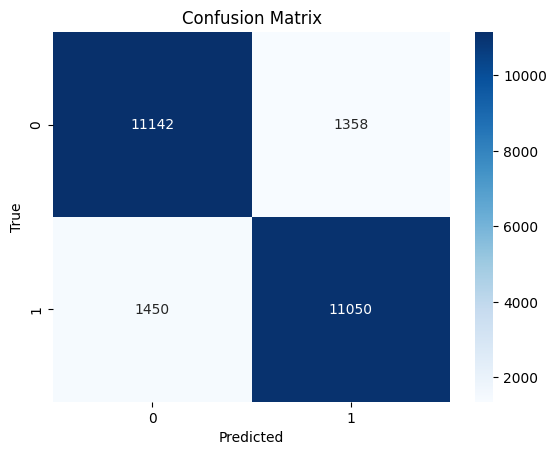

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

In [9]:
# Hata analizi: Yanlış tahmin edilen örnekleri inceleme
word_index = imdb.get_word_index()
reverse_word_index = {value + 3: key for key, value in word_index.items()}
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i, '?') for i in encoded_review if i > 0])

x_test_texts = [decode_review(x) for x in x_test]
incorrect_indices = np.where(y_pred.flatten() != y_test)[0]
print("\nExamples of Incorrect Predictions (first 5):")
for i in incorrect_indices[:5]:
    print(f"Review: {x_test_texts[i][:200]}...")
    print(f"True Label: {y_test[i]}, Predicted Label: {y_pred[i][0]}\n")


Examples of Incorrect Predictions (first 5):
Review: ? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen...
True Label: 0, Predicted Label: 1

Review: ? hollywood had a long love affair with bogus ? nights tales but few of these products have stood the test of time the most memorable were the jon hall maria ? films which have long since become camp ...
True Label: 0, Predicted Label: 1

Review: ? ed ? mitchell is a teenager who lives for his job at good ? a small but friendly neighborhood ? stand while his buddy ? thompson also works there but lack ? single minded devotion to his job he's th...
True Label: 0, Predicted Label: 1

Review: ? how managed to avoid attention remains a mystery a potent mix of comedy and crime this one takes chances where tarantino plays it safe with the hollywood formula the risks don't always pay off one c...
T